# Interspeech 2026

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers.utils.notebook import NotebookProgressBar

import torchaudio.transforms as T

from voicestudio.utils.audio_utils import show_waveform
import matplotlib.pyplot as plt

### Check GPU Availability

In [3]:
!nvidia-smi

Sat Feb 21 02:36:00 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX PRO 6000 Blac...    Off |   00000000:01:00.0 Off |                    0 |
| 30%   37C    P5             36W /  300W |      18MiB /  97887MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Set CUDA Device Number
DEVICE_NUM = 0

if torch.cuda.is_available():
    device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

device_map = f"cuda:{DEVICE_NUM}" if DEVICE_NUM >= 0 else "cpu"
print(f"INFO: Using device - {device}")

INFO: Using device - cuda:0


## Datasets

In [5]:
from spk_incon.datasets import LIBRITTS_P_Custom
from spk_incon.datasets.libritts_p3 import download_libritts_p_metadata

In [6]:
DATA_ROOT = "./data"
Z_THRESHOLD = 2
URL = "https://dolab-data.duckdns.org/api/public/dl/-qA96ilN"

In [7]:
if not os.path.isfile(os.path.join(DATA_ROOT, "train-clean-100.tar.gz")):
    !wget -O "./data/train-clean-100.tar.gz" {URL}

In [8]:
download_libritts_p_metadata(root=DATA_ROOT, annotator="df1")
curated_dataset = LIBRITTS_P_Custom(root=DATA_ROOT, download=True, max_z_score=3)
all_dataset = LIBRITTS_P_Custom(root=DATA_ROOT, download=True, max_z_score=float("inf"))

[INFO] Loading cached dataset from data/.cache/libritts_p_train-clean-100/dataset...
[INFO] Filtering outliers (max_z_score=3)...
[INFO] Filtered: 33187 -> 31067 samples.
[INFO] Loading cached dataset from data/.cache/libritts_p_train-clean-100/dataset...
[INFO] Filtering outliers (max_z_score=inf)...
[INFO] Filtered: 33187 -> 33187 samples.


## Models

In [9]:
from transformers import AutoTokenizer, AutoProcessor

from voicestudio.models.parler_tts import ParlerTTSForConditionalGeneration
from voicestudio.models.qwen3_tts import Qwen3TTSForConditionalGeneration

In [10]:
from spk_incon.models.selective_tuner import SelectiveTunerForConditionalGeneration, SelectiveTunerConfig
from spk_incon.components.style_anchor import DirectStyleAnchorEmbedding, EncoderStyleAnchorEmbedding, MixedStyleAnchorEmbedding

### Model Selection

In [11]:
# Model select
#model_id = "parler-tts/parler-tts-mini-v1"
#model_id = "parler-tts/parler-tts-large-v1"
#model_id = "parler-tts/parler-tts-mini-v1.1"

#model_id = "Qwen/Qwen3-TTS-12Hz-1.7B-Base"
model_id = "Qwen/Qwen3-TTS-12Hz-1.7B-VoiceDesign"

In [12]:
# Model loading
if "parler" in model_id.lower():
    model = ParlerTTSForConditionalGeneration.from_pretrained(
        model_id, device_map=device_map
    )
    config = model.config
    model_dtype = model.dtype
    processor = AutoProcessor.from_pretrained(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
elif "qwen" in model_id.lower():
    model = Qwen3TTSForConditionalGeneration.from_pretrained(
        model_id, device_map=device_map, dtype=torch.bfloat16, attn_implementation="flash_attention_2",
    )
    config = model.config
    model_dtype = model.dtype
    processor = AutoProcessor.from_pretrained(model_id, device_map=device_map)
    tokenizer = processor.tokenizer
else:
    pass

model.eval()

You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Qwen3TTSForConditionalGeneration(
  (talker): Qwen3TTSTalkerForConditionalGeneration(
    (model): Qwen3TTSTalkerModel(
      (layers): ModuleList(
        (0-27): 28 x Qwen3TTSTalkerDecoderLayer(
          (self_attn): Qwen3TTSTalkerAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_norm): Qwen3TTSRMSNorm((128,), eps=1e-06)
            (k_norm): Qwen3TTSRMSNorm((128,), eps=1e-06)
          )
          (mlp): Qwen3TTSTalkerTextMLP(
            (gate_proj): Linear(in_features=2048, out_features=6144, bias=False)
            (up_proj): Linear(in_features=2048, out_features=6144, bias=False)
            (down_proj): Linear(in_features=6144, out_features=2048, bias=False)
            (act_fn): SiLUActivation

### Embedding-tuner Selection

In [13]:
# Mode settings
USING_STRUCT_A = False  # if false prompt template struct B will be used

print(f"BOS token: {tokenizer.bos_token}, ID: {tokenizer.bos_token_id}")
print(f"EOS token: {tokenizer.eos_token}, ID: {tokenizer.eos_token_id}")
print(f"PAD token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}")

im_start_id = tokenizer.convert_tokens_to_ids("<|im_start|>")
im_end_id = tokenizer.convert_tokens_to_ids("<|im_end|>")

print(f"<|im_start|> token_id: {im_start_id}")
print(f"<|im_end|> token_id: {im_end_id}")

BOS token: None, ID: None
EOS token: <|im_end|>, ID: 151645
PAD token: <|endoftext|>, ID: 151643
<|im_start|> token_id: 151644
<|im_end|> token_id: 151645


In [14]:
# Token definitions
STYLE_TOKEN = "<|style|>"
STYLE_TOKEN_ID = len(tokenizer)
CONSISTENCY_TOKEN = "<|consistency|>"
CONSISTENCY_TOKEN_ID = len(tokenizer) + 1

anchor_token = STYLE_TOKEN, CONSISTENCY_TOKEN
anchor_token_id = STYLE_TOKEN_ID, CONSISTENCY_TOKEN_ID

In [15]:
trainable_indices = torch.tensor(anchor_token_id)

def make_mask_hook(indices, vocab_size):
    mask = torch.zeros(vocab_size)
    mask[indices] = 1.0

    def hook(grad):
        m = mask.to(dtype=grad.dtype, device=grad.device)
        return grad * m.unsqueeze(1)
    return hook

In [16]:
# Config setup
if "parler" in model_id.lower():
    hidden_size = config.decoder.hidden_size
elif "qwen" in model_id.lower():
    vocab_size = config.talker_config.text_vocab_size
    hidden_size = config.talker_config.hidden_size
    with torch.no_grad():
        embed = model.talker.get_text_embeddings()
        im_start_embed = embed.weight[im_start_id].clone()
        im_end_embed = embed.weight[im_end_id].clone()

        # register hook & init embedding weights
        embed.weight[CONSISTENCY_TOKEN_ID] = im_start_embed
        embed.weight[STYLE_TOKEN_ID] = im_end_embed
        embed.weight.register_hook(
            make_mask_hook(trainable_indices, config.talker_config.text_vocab_size)
        )
else:
    pass

hidden_size, vocab_size

(2048, 151936)

In [17]:
# Extend vocabulary
num_added = tokenizer.add_tokens(list(anchor_token))
assert STYLE_TOKEN_ID == tokenizer.convert_tokens_to_ids(STYLE_TOKEN)
assert CONSISTENCY_TOKEN_ID == tokenizer.convert_tokens_to_ids(CONSISTENCY_TOKEN)
print(f"INFO: Added {num_added} anchor tokens to tokenizer.")

INFO: Added 2 anchor tokens to tokenizer.


Setting `pad_token_id` to `eos_token_id`:2150 for open-end generation.


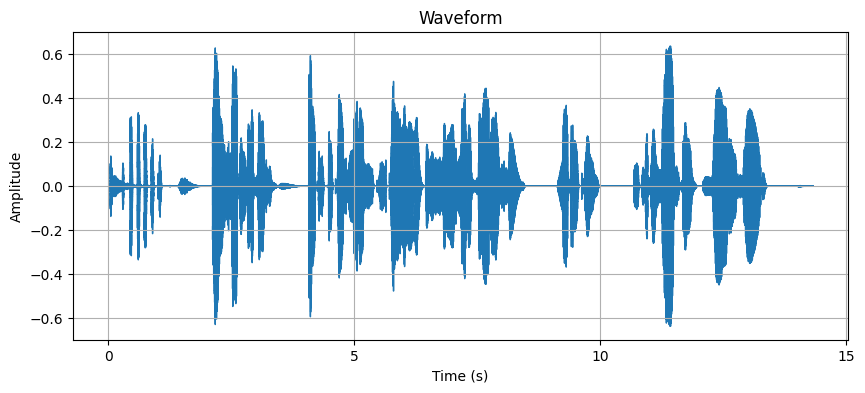

In [18]:
# Check model still works after modification
if "parler" in model_id.lower():
    prompt = "Hey, how are you doing today?"
    #description = "Jon's voice is monotone yet slightly fast in delivery, with a very close recording that almost has no background noise."
    description = "A female speaker delivers a slightly expressive and animated speech with a moderate speed and pitch. The recording is of very high quality, with the speaker's voice sounding clear and very close up."
    input_ids, prompt_input_ids = (tokenizer(d, return_tensors="pt").input_ids.to(device) for d in [description, prompt])

    outputs = model.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
    audio_values, sr = outputs.cpu().squeeze(), model.config.sampling_rate
elif "qwen" in model_id.lower():
    inputs = processor.encode_voice_design(
        text="I am solving the equation: x = [-b ± √(b²-4ac)] / 2a? Nobody can — it's a disaster (◍•͈⌔•͈◍), very sad!",
        instruct="Happy man describes the equation in a cheerful tone, with a hint of humor. He emphasizes the complexity of the equation and expresses his feelings about it in a lighthearted way.",
    )
    outputs = model.generate(**inputs)

    audio_values, sr = processor.decode(outputs)
    audio_values = torch.from_numpy(audio_values[0])
else:
    pass

show_waveform(None, waveform=audio_values, sr=sr)

## DataLoader

In [19]:
BATCH_SIZE = 16, 8  # consistency, style

In [20]:
import random

STYLE_PREFIX = "The speaker's identity can be described as "

def randomize_speaker_identity(text, mean_k: int = 3):
    # 1. 기준이 되는 문구 설정
    delimiter = STYLE_PREFIX

    # 2. 기준 문구가 텍스트에 없으면 원본 그대로 반환
    if delimiter not in text:
        return text

    # 3. 기준 문구를 기점으로 앞부분(prefix)과 키워드 부분(keywords) 분리
    if text[-1] == ".":
        text = text[:-1]
    prefix, keywords_str = text.split(delimiter)

    # 4. 쉼표로 구분된 단어들을 리스트로 변환 (공백 제거)
    keywords = [k.strip() for k in keywords_str.split(',') if k.strip()]

    # 5. 랜덤하게 단어 선택 (최소 1개 이상의 단어는 남기도록 설정)
    # k값(남길 개수)을 1부터 전체 개수 사이에서 랜덤하게 결정합니다.
    num_to_keep = random.randint(mean_k, len(keywords))
    selected_keywords = random.sample(keywords, num_to_keep)

    return f"{prefix}{delimiter}{', '.join(selected_keywords)}."

# --- 테스트 실행 ---
_input_text = "Let a woman speaks with standard pitch, speaking speed and energy The speaker's identity can be described as sharp, feminine, intellectual, sexy, calm, elegant, lively, adult-like, powerful, tensed, fluent, slightly hard, clear."

print("원본:", _input_text)
print("결과 1:", randomize_speaker_identity(_input_text))
print("결과 2:", randomize_speaker_identity(_input_text))

원본: Let a woman speaks with standard pitch, speaking speed and energy The speaker's identity can be described as sharp, feminine, intellectual, sexy, calm, elegant, lively, adult-like, powerful, tensed, fluent, slightly hard, clear.
결과 1: Let a woman speaks with standard pitch, speaking speed and energy The speaker's identity can be described as elegant, intellectual, slightly hard, feminine, calm, powerful, sexy, adult-like.
결과 2: Let a woman speaks with standard pitch, speaking speed and energy The speaker's identity can be described as intellectual, lively, elegant, clear.


In [21]:
from functools import partial

def apply_user_promt(instruct: str, apply: bool = False):
    if not apply:
        return f"<|im_start|>user\n{instruct}<|im_end|>\n"
    else:
        return f"<|im_start|>user\n{randomize_speaker_identity(instruct)}<|im_end|>{STYLE_TOKEN}\n"

def apply_assistant_prompt(text: str, sim: bool = False):
    if not sim:
        return f"<|im_start|>assistant\n{text}<|im_end|>\n<|im_start|>assistant\n"
    elif USING_STRUCT_A:
        return f"<|im_start|>assistant\n{text}<|im_end|>\n{CONSISTENCY_TOKEN}<|im_start|>assistant\n"
    else:
        return f"{CONSISTENCY_TOKEN}<|im_start|>assistant\n{text}<|im_end|>\n<|im_start|>assistant\n"

if "qwen" in model_id.lower():
    processor._build_assistant_text = partial(apply_assistant_prompt, sim=True)
    processor._build_instruct_text = partial(apply_user_promt, apply=True)

In [22]:
sample_data = curated_dataset[50]
sample_data_organized = dict(
    instruction=sample_data['combined_prompt'],
    text=sample_data['normalized_text'],
    output=sample_data['waveform'],
    sample_rate=sample_data['sample_rate']
)
sample_data_organized

{'instruction': "ask a woman with normal pitch to speak with low volume and slow speaking speed The speaker's identity can be described as intellectual, slightly young, sharp, feminine, tensed, calm, lively, powerful, fluent, clear.",
 'text': '"Well now, I dunno," said matthew.',
 'output': tensor([[0.0031, 0.0028, 0.0033,  ..., 0.0027, 0.0026, 0.0024]]),
 'sample_rate': 24000}

In [23]:
def collate_fn(batch_list: list, apply_style_token: bool = False):
    instructions = [item['combined_prompt'] for item in batch_list]
    texts = [item['normalized_text'] for item in batch_list]
    sims = [item['distance_z_score'] < Z_THRESHOLD for item in batch_list]

    outputs = [item['waveform'].cpu().numpy() for item in batch_list]
    sample_rates = [item['sample_rate'] for item in batch_list]

    # ── 1. audio → codec codes ──────────────────────────────────────────
    prompt_codes = []  # list of (T, 16)
    for wav, sr in zip(outputs, sample_rates):
        audio_list = processor._normalize_audio_inputs([wav], sr)
        feature_inputs = processor.feature_extractor(
            raw_audio=audio_list,
            sampling_rate=int(processor.feature_extractor.sampling_rate),
            return_tensors="pt"
        ).to(device).to(processor.audio_tokenizer.dtype)

        with torch.inference_mode():
            audio_outputs = processor.audio_tokenizer.encode(
                feature_inputs["input_values"].squeeze(1),
                feature_inputs["padding_mask"].squeeze(1),
                return_dict=True,
            )
        prompt_codes.append(audio_outputs.audio_codes[0])  # (C, 16)

    # ── 2. text tokenize ─────────────────────────────────────────────────
    text_id_list = []
    instruct_id_list = []
    for text, instruct, sim in zip(texts, instructions, sims):
        t_ids = tokenizer(apply_assistant_prompt(text, sim), return_tensors="pt").input_ids  # (1, L)
        i_ids = tokenizer(apply_user_promt(instruct, apply_style_token), return_tensors="pt").input_ids  # (1, Li)
        text_id_list.append(t_ids)
        instruct_id_list.append(i_ids)

    # ── 3. embedding 계산 및 context 구성 ───────────────────────────────
    talker = model.talker
    cfg = model.config

    def text_embed(ids):
        return talker.text_projection(talker.get_text_embeddings()(ids.to(device)))

    def codec_embed_0(ids):
        return talker.get_input_embeddings()(ids.to(device))

    sample_embeds = []
    codec_0_labels_list = []
    codec_ids_list = []
    codec_mask_list = []

    for t_ids, ins_ids, codes in zip(text_id_list, instruct_id_list, prompt_codes):
        # t_ids: (1, L),  codes: (C, 16)
        C = codes.shape[0]
        text_body_len = t_ids.shape[1] - 3 - 5  # role(3) + trailing(5) 제외

        tts_bos_embed, tts_eos_embed, tts_pad_embed = text_embed(
            torch.tensor([[cfg.tts_bos_token_id, cfg.tts_eos_token_id, cfg.tts_pad_token_id]])
        ).chunk(3, dim=1)  # 각 (1, 1, D)

        # ① instruct: text channel만
        e_instruct = text_embed(ins_ids)  # (1, Li, D)

        # ② role: "<|im_start|>assistant\n" (3 tokens)
        e_role = text_embed(t_ids[:, :3])  # (1, 3, D)

        # ③ codec prefix(4칸): text=[tts_pad*3, tts_bos], codec=[nothink, think_bos, think_eos, codec_pad]
        e_codec_prefix = codec_embed_0(
            torch.tensor([[
                cfg.talker_config.codec_nothink_id,
                cfg.talker_config.codec_think_bos_id,
                cfg.talker_config.codec_think_eos_id,
                cfg.talker_config.codec_pad_id,
            ]])
        )  # (1, 4, D)
        e_text_prefix = torch.cat([
            tts_pad_embed.expand(-1, 3, -1),
            tts_bos_embed,
        ], dim=1)  # (1, 4, D)
        e_prefix = e_text_prefix + e_codec_prefix  # (1, 4, D)

        # ④ text body + tts_eos / codec=codec_pad
        e_text_body = torch.cat([
            text_embed(t_ids[:, 3:-5]),  # (1, text_body_len, D)
            tts_eos_embed,               # (1, 1, D)
        ], dim=1)  # (1, text_body_len+1, D)
        e_codec_pad_body = codec_embed_0(
            torch.tensor([[cfg.talker_config.codec_pad_id] * (text_body_len + 1)])
        )  # (1, text_body_len+1, D)
        e_body = e_text_body + e_codec_pad_body  # (1, text_body_len+1, D)

        # ⑤ codec_bos: text=tts_pad, codec=codec_bos
        e_codec_bos = tts_pad_embed + codec_embed_0(
            torch.tensor([[cfg.talker_config.codec_bos_id]])
        )  # (1, 1, D)

        # ⑥ audio codec tokens: text=tts_pad, codec=sum of all quantizers
        e_audio = tts_pad_embed.expand(-1, C, -1).clone()
        e_audio = e_audio + codec_embed_0(codes[:, 0].unsqueeze(0))  # codebook 0
        for q in range(1, 16):
            e_audio = e_audio + talker.code_predictor.get_input_embeddings()[q-1](
                codes[:, q].unsqueeze(0)
            )  # (1, C, D)

        # ⑦ codec EOS: text=tts_pad, codec=codec_eos
        e_codec_eos = tts_pad_embed + codec_embed_0(
            torch.tensor([[cfg.talker_config.codec_eos_token_id]])
        )  # (1, 1, D)

        # 전체 concat
        full_embed = torch.cat([
            e_instruct,   # (1, Li, D)
            e_role,       # (1, 3, D)
            e_prefix,     # (1, 4, D)
            e_body,       # (1, text_body_len+1, D)
            e_codec_bos,  # (1, 1, D)
            e_audio,      # (1, C, D)
            e_codec_eos,  # (1, 1, D)
        ], dim=1)  # (1, T, D)
        sample_embeds.append(full_embed)

        # labels: codec 구간 + EOS만 살리고 나머지 -100
        total_len = full_embed.shape[1]
        prefix_len = ins_ids.shape[1] + 3 + 4 + (text_body_len + 1) + 1  # codec token 시작 위치
        labels = torch.full((total_len,), -100, dtype=torch.long)
        labels[prefix_len: prefix_len + C] = codes[:, 0]
        labels[prefix_len + C] = cfg.talker_config.codec_eos_token_id
        codec_0_labels_list.append(labels)

        # codec_ids: (total_len, 16)
        cids = torch.zeros(total_len, 16, dtype=torch.long)
        cids[prefix_len: prefix_len + C] = codes
        codec_ids_list.append(cids)

        # codec_mask: audio codec 구간만 True (EOS 제외 — sft_12hz.py 동일)
        cmask = torch.zeros(total_len, dtype=torch.bool)
        cmask[prefix_len: prefix_len + C] = True
        codec_mask_list.append(cmask)

    # ── 4. left-padding & batch ──────────────────────────────────────────
    B = len(sample_embeds)
    seqs = [e.squeeze(0) for e in sample_embeds]
    original_lengths = torch.tensor([s.shape[0] for s in seqs])
    max_len = original_lengths.max().item()

    # inputs_embeds: left pad
    seqs_rev = [s.flip(0) for s in seqs]
    padded_rev = torch.nn.utils.rnn.pad_sequence(seqs_rev, batch_first=True, padding_value=0.0)
    inputs_embeds = padded_rev.flip(1).to(device)  # (B, max_len, D)

    # attention_mask
    num_pads = max_len - original_lengths
    indices = torch.arange(max_len).expand(B, -1)
    attention_mask = (indices >= num_pads.unsqueeze(1)).long().to(device)

    # labels, codec_ids, codec_mask: left pad
    codec_0_labels = torch.full((B, max_len), -100, dtype=torch.long)
    codec_ids      = torch.zeros(B, max_len, 16, dtype=torch.long)
    codec_mask     = torch.zeros(B, max_len, dtype=torch.bool)

    for i, (lab, cids, cmask, l) in enumerate(zip(codec_0_labels_list, codec_ids_list, codec_mask_list, original_lengths)):
        codec_0_labels[i, max_len - l:] = lab
        codec_ids[i, max_len - l:]      = cids
        codec_mask[i, max_len - l:]     = cmask

    codec_0_labels = codec_0_labels.to(device)
    codec_ids      = codec_ids.to(device)
    codec_mask     = codec_mask.to(device)

    return dict(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        codec_0_labels=codec_0_labels,
        codec_ids=codec_ids,
        codec_mask=codec_mask,
    )

In [24]:
from functools import partial

consistency_loader = DataLoader(curated_dataset, batch_size=BATCH_SIZE[0], shuffle=True, collate_fn=collate_fn)
style_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE[1], shuffle=True, collate_fn=partial(collate_fn, apply_style_token=True))

## Training

### Set trainable params

In [25]:
for param in model.parameters():
    param.requires_grad = False

for module in model.modules():
    if hasattr(module, 'q_proj') and hasattr(module, 'k_proj'):
        print(f"INFO: Unfreezing Q and K projections in: {type(module).__name__}")
        module.q_proj.weight.requires_grad = True
        module.k_proj.weight.requires_grad = True
        if module.q_proj.bias is not None:
            module.q_proj.bias.requires_grad = True
        if module.k_proj.bias is not None:
            module.k_proj.bias.requires_grad = True

INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention
INFO: Unfreezing Q and K 

In [26]:
import re

STYLE_LAYERS = [0, 1, 2, 3]       # instruct 처리 초반 레이어
SINK_LAYERS  = [3, 4, 5]          # attention map에서 sink 뚜렷했던 레이어
TARGET_LAYERS = set(STYLE_LAYERS) | set(SINK_LAYERS)  # {0,1,2,3,4,5}

for param in model.parameters():
    param.requires_grad = False


for name, module in model.named_modules():
    if hasattr(module, 'q_proj') and hasattr(module, 'k_proj'):
        match = re.search(r'\.(\d+)\.', name)
        if not match: continue
        layer_idx = int(match.group(1))
        if layer_idx in TARGET_LAYERS:
            print(f"INFO: Unfreezing Q and K projections in: {type(module).__name__} [{layer_idx}th]")
            module.q_proj.weight.requires_grad = True
            module.k_proj.weight.requires_grad = True
            if module.q_proj.bias is not None:
                module.q_proj.bias.requires_grad = True
            if module.k_proj.bias is not None:
                module.k_proj.bias.requires_grad = True

INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention [0th]
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention [1th]
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention [2th]
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention [3th]
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention [4th]
INFO: Unfreezing Q and K projections in: Qwen3TTSTalkerAttention [5th]
INFO: Unfreezing Q and K projections in: Qwen3TTSAttention [0th]
INFO: Unfreezing Q and K projections in: Qwen3TTSAttention [1th]
INFO: Unfreezing Q and K projections in: Qwen3TTSAttention [2th]
INFO: Unfreezing Q and K projections in: Qwen3TTSAttention [3th]
INFO: Unfreezing Q and K projections in: Qwen3TTSAttention [4th]


In [27]:
if "qwen" in model_id.lower():
    print("INFO: Unfreezing token embeddings in talker...")
    model.talker.get_text_embeddings().weight.requires_grad = True

INFO: Unfreezing token embeddings in talker...


### Fine-tuning

In [28]:
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
SAVE_PERIOD = 100
OUTPUT_DIR = "./results/" + model_id

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [29]:
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=LEARNING_RATE, weight_decay=0.01)
epoch_steps = int(len(curated_dataset) / BATCH_SIZE[0] + 0.99)
total_steps = epoch_steps * NUM_EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=LEARNING_RATE/100)

print(f"INFO: dataset len={len(curated_dataset)}, total_steps={total_steps}")

INFO: dataset len=31067, total_steps=19420


In [30]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

# 파라미터 그룹 분리
embed_params = [model.talker.get_text_embeddings().weight]
qk_params = [
    p for name, p in model.named_parameters()
    if p.requires_grad and 'embed' not in name
]

optimizer = AdamW([
    {"params": embed_params, "lr": 1e-3},
    {"params": qk_params,    "lr": 2e-5},
], weight_decay=0.01)

# Scheduler
warmup_steps = 100
cosine_steps = total_steps - warmup_steps

warmup = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
cosine = CosineAnnealingLR(optimizer, T_max=cosine_steps, eta_min=2e-6)  # embed eta_min도 2e-4로 따로 쓰고 싶으면 param group별 scheduler 분리 필요
scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_steps])

In [31]:
START_EPOCH = 1

In [32]:
def remove_dtype(config):
    config.__dict__.pop('dtype', None)
    for v in config.__dict__.values():
        from transformers import PretrainedConfig
        if isinstance(v, PretrainedConfig):
            remove_dtype(v)

remove_dtype(model.config)

In [ ]:
model.train()

total_bar = NotebookProgressBar(NUM_EPOCHS, prefix="Running Epochs")
for epoch in range(START_EPOCH-1, NUM_EPOCHS+0):
    total_bar.update(epoch+1)
    train_loss, train_mfcc = [], []

    train_bar = NotebookProgressBar(epoch_steps, prefix=f"Training {epoch+1}")
    for i, input_zipped in enumerate(zip(consistency_loader, style_loader)):
        optimizer.zero_grad()
        current_loss = 0

        for inputs in input_zipped:
            try:
                if "qwen" in model_id.lower():
                    outputs = model.talker(
                        inputs_embeds=inputs['inputs_embeds'][:, :-1, :],
                        attention_mask=inputs['attention_mask'][:, :-1],
                        labels=inputs['codec_0_labels'][:, 1:],
                        output_hidden_states=True
                    )

                    hidden_states = outputs.hidden_states[0][-1]

                    # codec_mask도 :-1 로 잘라서 inputs_embeds와 길이 맞추기
                    codec_mask_shifted = inputs['codec_mask'][:, :-1]
                    talker_hidden_states = hidden_states[codec_mask_shifted]
                    talker_codec_ids = inputs['codec_ids'][:, :-1][codec_mask_shifted]

                    sub_talker_logits, sub_talker_loss = model.talker.forward_sub_talker_finetune(
                        talker_codec_ids, talker_hidden_states
                    )
                    outputs.loss = outputs.loss + 0.3 * sub_talker_loss
                else:
                    outputs = model(**inputs)
            except (torch.cuda.OutOfMemoryError, RuntimeError):
                import gc
                gc.collect()
                torch.cuda.empty_cache()
                continue

            outputs.loss.backward()
            current_loss += outputs.loss.item()

        optimizer.step()
        scheduler.step()

        train_loss.append(current_loss)

        if (i+1) % SAVE_PERIOD == 0: model.save_pretrained(OUTPUT_DIR+f"_epoch{epoch+1}_iter{i}")
        if i+1 != train_bar.total: train_bar.update(i+1, comment=f"Loss={current_loss:.5f}, LR={optimizer.param_groups[0]['lr']:.1e}")

    model.save_pretrained(OUTPUT_DIR+f"_epoch{epoch+1}")
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    train_bar.update(train_bar.total, comment=f"Loss={sum(train_loss)/len(train_loss):.5f}, LR={optimizer.param_groups[0]['lr']:.1e}")

In [ ]:
model.save_pretrained(OUTPUT_DIR+"_last")

## Testing

In [ ]:
from spk_incon.metrics.presets import DatasetType, GenerationMethod, SynthesisConfig, ModelType
from spk_incon.metrics.strategies import create_strategy
from spk_incon.datasets import DatasetType, create_dataset

from spk_incon.utils.evaluate import EvaluationPipeline

In [ ]:
test_config = SynthesisConfig()
test_dataset_type = DatasetType.LIBRITTS
test_dataset_config = test_config.get_dataset_config(test_dataset_type.value)

In [ ]:
test_dataset = create_dataset(test_dataset_type, test_dataset_config, root_dir="./data")

In [ ]:
from pathlib import Path
import random

import numpy as np
import torch

import soundfile as sf


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class TestModel:
    @classmethod
    def seed_everything(cls, seed: int = 42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    @classmethod
    def synthesize(
        cls,
        text: str,
        output_path: Path,
        reference_audio: Path | None = None,
        style_prompt: str | None = None,
        speaker_id: str | None = None
    ) -> bool:
        cls.seed_everything()
        output_path.parent.mkdir(parents=True, exist_ok=True)

        # Setup generation config
        generation_config = dict(
            #top_k=1,
        )

        # Input preparation
        if "parler" in model_id.lower():
            inputs = dict(
                input_ids=tokenizer(style_prompt, return_tensors="pt").input_ids.to(device),
                prompt_input_ids=tokenizer(text, return_tensors="pt").input_ids.to(device)
            )
        elif "qwen" in model_id.lower():
            inputs = processor.encode_voice_design(
                text=text, instruct=style_prompt,
            )

        # Generation
        outputs = model.generate(**inputs, **generation_config)

        # Decoding
        if "parler" in model_id.lower():
            audio_values = outputs.cpu().numpy().squeeze()
            sample_rate = config.audio_encoder.sampling_rate
        elif "qwen" in model_id.lower():
            audio_values, sample_rate = processor.decode(outputs)
            audio_values = audio_values[0]

        # Save audio
        sf.write(output_path, audio_values, sample_rate)
        try:
            return output_path.stat().st_size > 0
        except FileNotFoundError:
            return False

In [ ]:
from enum import Enum

class ModelType(Enum):
    TEST = model.__class__.__name__

In [ ]:
from pathlib import Path

test_model_type = ModelType.TEST
test_model = TestModel()

try:
    evaluator = EvaluationPipeline(base_dir=Path(OUTPUT_DIR+f"_epoch{epoch+1}"))
    test_config.generation.output_dir = Path(OUTPUT_DIR+f"_epoch{epoch+1}")
except UnboundLocalError:
    evaluator = EvaluationPipeline(base_dir=Path(OUTPUT_DIR+"_last"))
    test_config.generation.output_dir = Path(OUTPUT_DIR+"_last")

### Experiment 2

In [ ]:
strategy = create_strategy(GenerationMethod.METHOD2, test_config, test_dataset, test_model)
exp2_result = strategy.generate_all(test_dataset_type.value, test_model_type.value)
exp2_result

In [ ]:
exp2_eval_result = evaluator.evaluate_dataset_model(
    dataset_type=test_dataset_type,
    model_type=test_model_type,
    methods=[GenerationMethod.METHOD2]
)
evaluator.save_results_to_csv(exp2_eval_result, test_dataset_type, test_model_type)

### Experiment 1

In [ ]:
strategy = create_strategy(GenerationMethod.METHOD1, test_config, test_dataset, test_model)
exp1_result = strategy.generate_all(test_dataset_type.value, test_model_type.value)
exp1_result

In [ ]:
exp1_eval_result = evaluator.evaluate_dataset_model(
    dataset_type=test_dataset_type,
    model_type=test_model_type,
    methods=[GenerationMethod.METHOD1]
)
evaluator.save_results_to_csv(exp1_eval_result, test_dataset_type, test_model_type)

### Experiment 3

In [ ]:
strategy = create_strategy(GenerationMethod.METHOD3, test_config, test_dataset, test_model)
exp3_result = strategy.generate_all(test_dataset_type.value, test_model_type.value)
exp3_result

In [ ]:
exp3_eval_result = evaluator.evaluate_dataset_model(
    dataset_type=test_dataset_type,
    model_type=test_model_type,
    methods=[GenerationMethod.METHOD3]
)
evaluator.save_results_to_csv(exp3_eval_result, test_dataset_type, test_model_type)